# Assignment
**Fast patent classification from abstract:** 
I choose to work on a binary classification problem ( is the patent of class A or B ) using only the abstract as input 

 - Dataset:    Wipo-alpha data https://www.wipo.int/classifications/ipc/en/ITsupport/Categorization/dataset/wipo-alpha-readme.html
 - total size: 5'000 patents
 

 - model 1:    I use glove.6B.50d.txt
 - model 2:    I use W2Vec_Patent_Domain.txt from https://www.kaggle.com/darshmso/w2vec-patent-domain
 - model 3:    I use pre-trained openai GPT-2 (small 124M)
 
- Hardware:  &nbsp; &nbsp;private GPU, GTX 1060 with CUDA

- Keras: &nbsp; &nbsp; &nbsp;  &nbsp; &nbsp; v 2.3.1
- Tensorflow:  &nbsp; v 2.1 released on 08/01/2020  *tensorflow pip package now includes GPU support by default (same as tensorflow-gpu)*
- submission time: 25.02.2020 at 12:00


In [ ]:
import os
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics
from xml.etree import cElementTree as ElementTree
import xml.etree.ElementTree as ET
import pandas as pd
import glob
import pandas as pd
import re, sys, os, csv, keras, pickle
import matplotlib.pyplot as plt
import sys
sys.path.append("../../../../")

Using TensorFlow backend.


In [ ]:
# https://stackoverflow.com/questions/51181754/keras-tensorflow-convlstm2d-object-has-no-attribute-outbound-nodes 
from tensorflow.python.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.python.keras.layers import Embedding
from tensorflow.python.keras.layers import Dense, Input, Flatten, Concatenate
from tensorflow.python.keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional
from tensorflow.python.keras.models import Model
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D
from tensorflow.python.keras.layers import Bidirectional, MaxPooling1D
from tensorflow.python.keras.layers import ZeroPadding1D
from tensorflow.python.keras.models import Model
from tensorflow.python.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.python.keras.layers import Flatten, Bidirectional,CuDNNGRU
from tensorflow.python.keras.optimizers import Adam
# from tensorflow.python.keras.engine.topology import Layer, InputSpec
print("Keras version:",keras.__version__)

Keras version: 2.3.1


In [ ]:
np.random.seed(53)

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16049772792071505356
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4930941747
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8426851189057038607
physical_device_desc: "device: 0, name: GeForce GTX 1060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


# Utilities / UDF

user defined functions

In [ ]:
# convert-xml-to-pandas-dataframe : 
# http://www.austintaylor.io/lxml/python/pandas/xml/dataframe/2016/07/08/convert-xml-to-pandas-dataframe/
from collections import defaultdict

def etree_to_dict(t):
    d = {t.tag: {} if t.attrib else None}
    children = list(t)
    if children:
        dd = defaultdict(list)
        for dc in map(etree_to_dict, children):
            for k, v in dc.items():
                dd[k].append(v)
        d = {t.tag: {k:v[0] if len(v) == 1 else v for k, v in dd.items()}}
    if t.attrib:
        d[t.tag].update(('@' + k, v) for k, v in t.attrib.items())
    if t.text:
        text = t.text.strip()
        if children or t.attrib:
            if text:
              d[t.tag]['#text'] = text
        else:
            d[t.tag] = text
    return d

In [ ]:
from xml.etree import cElementTree as ET
from pprint import pprint as pp
    
def xml2dict(xml_file):
    parser = ET.XMLParser(encoding="utf-8")
    # dtd = etree.DTD(dtd_file)
    tree = ET.parse(xml_file,parser=parser)
    e = tree.getroot()

    # pprint(etree_to_dict(e))
    return etree_to_dict(e)

In [ ]:
def _load_data(directory, limit = 10):
    files = [f for f in glob.glob(directory + "**/*.xml", recursive=True)]
    df = pd.DataFrame(columns=["abstract_raw"])
    total = 0

    for file in files:    
        try:
            dico = xml2dict(file)
            abstract = dico['record']['abs']['ab']['#text']
            df = df.append({"abstract_raw":abstract},ignore_index=True, )
            total += 1
        except:
            pass

        if total>=limit:
            break;
    return df

In [ ]:
def load_data():
    df_A = _load_data(root_A, limit = data_size//2)
    df_A["class"] = 0.0 # one hot encoded
    print(f"[+] {len(df_A)} report of class A loaded.")
    df_B = _load_data(root_B, limit = data_size//2)
    df_B["class"] = 1.0
    print(f"[+] {len(df_B)} report of class B loaded.")
    
    return pd.concat([df_A,df_B]).reset_index(drop=True)

In [ ]:
def y_lim(list_a, list_b):
    '''return the max in the last 25% of a serie'''
    return max(  max(list_a[int(len(list_b)*0.75):])   ,   max(list_b[int(len(list_b)*0.75):])  )


def plot_history(history,target_label="",metrics=["acc"]):
    '''Plot the metrics after training'''
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    #print("last epoch:   val_mae", int(list(hist['val_mae'])[-1]*train_std), 'val_mse',
    #      int(list(hist['val_mse'])[-1]*train_std*train_std))
    print("history.tail:")
    print(hist.tail())
    
    for metric in metrics:
        #try:
        fig = plt.figure(figsize=(6.4*2.0, 4))
        for i in [1,2]:
            ax = fig.add_subplot(1,2,i)
            plt.xlabel('Epoch')
            plt.ylabel('{} [{}]'.format(metric,target_label))
            plt.plot(hist['epoch'], hist[metric], label='Train Error')
            plt.plot(hist['epoch'], hist['val_'+metric], label = 'Val Error')
            if i==2:
                if metric in ['accuracy','acc']:
                    plt.ylim([0.5,1.0])
                else:    
                    plt.ylim([0,y_lim(hist[metric], hist['val_'+metric])* (2.0 if metric=='mae' else 3.0)])
            else:
                if metric in ['accuracy','acc']:
                    plt.ylim([0.0,1.0])
                
            plt.legend()
        plt.grid()
        plt.show()
        #except:
        #    plt.clf()    

In [ ]:
# embeddings_index[word] = embedding of the word
def load_embedding_index_from_file(file):
    embeddings_index = {}
    f = open(file, mode="r", encoding="utf-8")
    print("Loading embedding_index from:",file,"...",end="")
    for line in f:
        values = line.split()
        if len(values)<10:
            # print("[!] skipped line")
            continue
        word = values[0]
        embeddings_index[word] = np.asarray(values[1:], dtype='float32')
    f.close()
    return embeddings_index

In [ ]:
def get_embedding_matrix_from_embeddings_index(embeddings_index, nb_unique_words, EMBEDDING_DIM ):
    print("[+] Proceeding with Embedding Matrix...")
    embedding_matrix = np.random.random((nb_unique_words, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: ########################################### todo drop the non excisting words
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
        #else:
        #    print(word, end=", ") # this word do not have a embeded representation in the loaded model
    print("[i] Completed!")
    return embedding_matrix

# Configuration

In [ ]:
xml_file_example = "C:\\Users\\Karim\\Google Drive\\AAA\\Deep learning\\4-projet\\patent-classification-train\\alphatrain-A\\A\\01\\B\\001\\AU0100080_09082001.xml"
root = "C:\\Users\\Karim\\Google Drive\\AAA\\Deep learning\\4-projet\\patent-classification-train\\"

root_A = root + "alphatrain-A\\"
root_B = root + "alphatrain-B\\"
dtd_file = ''

data_size = 5000 # total on train val and test

MAX_NB_WORDS= 40000       # max number of unique words
MAX_SEQUENCE_LENGTH = 200 # max nb of words per abstract

EMBEDDING_DIM = 50
GloVe_file = f"glove.6B.{EMBEDDING_DIM}d.txt"    # downloaded from # http://nlp.stanford.edu/data/glove.6B.zip

- We split the data like this:
    - 50% train
    - 20% validation
    - 30% test

# Datasets: Load & Vizualize

Let's first load only one patent as a dictionary

In [ ]:
dico = xml2dict(xml_file_example)
dico

{'record': {'prs': {'pr': {'@prn': 'AU20000203 PQ 5409'}},
  'ipcs': {'ipc': [{'@ic': 'A01C00502'},
    {'@ic': 'E02D00104'},
    {'@ic': 'E21B02500'},
    {'@ic': 'E21B04902'}],
   '@ed': '7',
   '@mc': 'A01B00100'},
  'pas': {'pa': 'MORRISON, Michael, Joseph'},
  'tis': {'ti': {'@{http://www.w3.org/XML/1998/namespace}lang': 'EN',
    '#text': 'SOIL MANIPULATING TOOL'}},
  'abs': {'ab': {'@{http://www.w3.org/XML/1998/namespace}lang': 'EN',
    '#text': 'A soil manipulating tool is disclosed which has a handle (12) and a soil penetrating portion\n(14). The soil penetrating portion (14) is formed from a helical or spiral rod\nor wire (13) which defines a cavity (18). The rod or wire (13) may be hollow so that\nfertilizer or other liquid material can pass through the hollow rod wire (13)\ninto the soil in which the tool is to be used. The tool may also include an abutment member\nfor limiting the amount of penetration of the tool into the soil to facilitate churning\nup of the soil and a

**features:**
- **I choose to work with Abstract only as input**
- we will only extract abstract under 'abs'->'ab'->'#text'

In [ ]:
df = load_data()

print("df.shape=",df.shape)
df

[+] 2500 report of class A loaded.
[+] 2500 report of class B loaded.
df.shape= (5000, 2)


,abstract_raw,class
0,A soil manipulating tool is disclosed which ha...,0.0
1,A movable device to facilitate removal of plan...,0.0
2,An impact cushioning device (10) comprising: a...,0.0
3,A device for uprooting a plant comprises a lev...,0.0
4,"Garden tool, formed by a shaft with at one out...",0.0
...,...,...
4995,A refill jig for an ink cartridge having a pri...,1.0
4996,Inkjet printhead with array of parallel channe...,1.0
4997,A flexure (1) of the type comprising a pair of...,1.0
4998,A multi nozzle CIJ printhead has a number of i...,1.0


## text to integers
source code inspired from: https://github.com/glmack/patent_predict_nlp/blob/784471276f4ed70b584e18806e2af1d99f39d578/patent_predict.ipynb

In [ ]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
texts = df["abstract_raw"]
tokenizer.fit_on_texts(texts)

Convert txt to sequences of word tokens with zero padding at the front and back

In [ ]:
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('[i] Found %s unique tokens.' % len(word_index))
data_int = pad_sequences(sequences, padding='pre', maxlen=(MAX_SEQUENCE_LENGTH-5))
data = pad_sequences(data_int, padding='post', maxlen=(MAX_SEQUENCE_LENGTH))

[i] Found 16325 unique tokens.


In [ ]:
nb_unique_words = len(word_index) + 1

In [ ]:
data.shape

(5000, 200)

In [ ]:
data[0] # example of a abstract text transformed to a sequence of int with left/right padding

array([    0,     0,     0,     0,     0,     0,     0,     2,   586,
        3148,    87,     6,   153,    11,    36,     2,   180,    25,
           4,     2,   586,  3020,    34,    42,     1,   586,  3020,
          34,    42,     6,    79,    13,     2,  1759,    12,  1536,
         384,    12,   415,   119,    11,   727,     2,   183,    64,
           1,   384,    12,   415,   119,    55,    16,   340,    66,
          17,  4022,    12,    70,    82,    30,    48,   709,    49,
           1,   340,   384,   415,   119,    35,     1,   586,     7,
          11,     1,    87,     6,     5,    16,   116,     1,    87,
          55,    74,   266,     9,  1316,    32,     8,  2412,     1,
         493,     3,  2344,     3,     1,    87,    35,     1,   586,
           5,   908, 10668,   255,     3,     1,   586,     4,     2,
         129,    55,    74,    16,    52,   557,    20,     3,     1,
        5697,     3,     1,    34,    42,     5,   189,     2,  6325,
           3,   586,

## Input / Output

In [ ]:
input_data = data

In [ ]:
output_classes = [ c for c in df["class"]]

## split train test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    input_data, output_classes, test_size=0.33,
    stratify=output_classes, shuffle=True,
    random_state=53)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test =  np.array(y_test)

# model 1: GloVe
Consider Glove word embeddings as a Baseline approach

## Preparing the Embedding layer

In [ ]:
embeddings_index = load_embedding_index_from_file(GloVe_file)

Loading embedding_index from: glove.6B.50d.txt ...

In [ ]:
embedding_matrix = get_embedding_matrix_from_embeddings_index(embeddings_index, nb_unique_words, EMBEDDING_DIM )

[+] Proceeding with Embedding Matrix...
[i] Completed!


In [ ]:
embedding_matrix.shape # unique_words x EMBEDDING_DIM

(16326, 50)

## layers

In [ ]:
inp = Input(shape=(MAX_SEQUENCE_LENGTH,))
# Embedding layer gets ints et output a seq of embedding
# https://hpi.de/fileadmin/user_upload/fachgebiete/naumann/publications/2019/risch2019domainspecific.pdf
x = Embedding(nb_unique_words, EMBEDDING_DIM, weights=[embedding_matrix])(inp)
x.trainable = False # freeze the embedding layer because the dataset is too small
x = Bidirectional(CuDNNGRU(16, return_sequences=True))(x) # runs on Nvidia CUDA
x = MaxPooling1D()(x)
x = Flatten()(x)
x = Dense(16, activation="tanh")(x)
x = Dropout(rate=0.15)(x)
x = Dense(1, activation="sigmoid")(x)  # Classification problem => sigmoid
model = Model(inputs=inp, outputs=x)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 50)           816300    
_________________________________________________________________
bidirectional (Bidirectional (None, 200, 32)           6528      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 100, 32)           0         
_________________________________________________________________
flatten (Flatten)            (None, 3200)              0         
_________________________________________________________________
dense (Dense)                (None, 16)                51216     
_________________________________________________________________
dropout (Dropout)            (None, 16)                0     

In [ ]:
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=['accuracy'])

In [ ]:
# test if the model works
# test if the model works
# test if the model works
# test if the model works
# test if the model works
# test if the model works
# test if the model works
# test if the model works correclty
#prediction = model.predict([input_data], verbose=1)
#prediction[:5]

## train

In [ ]:
model1_history = model.fit([X_train],[y_train],
                    verbose=2, # batch_size=1024,
                    epochs=5,
                    validation_split = 0.2,
                    # callbacks=[early_stop, reduce_lr_onPlateau, tensorboard_callback, ManualEarlyStopping()])
                   )

Train on 2680 samples, validate on 670 samples
Epoch 1/5
2680/2680 - 9s - loss: 0.7482 - accuracy: 0.5093 - val_loss: 0.6831 - val_accuracy: 0.5403
Epoch 2/5
2680/2680 - 2s - loss: 0.6864 - accuracy: 0.5873 - val_loss: 0.6001 - val_accuracy: 0.6896
Epoch 3/5
2680/2680 - 2s - loss: 0.5362 - accuracy: 0.7313 - val_loss: 0.5068 - val_accuracy: 0.7582
Epoch 4/5
2680/2680 - 2s - loss: 0.3882 - accuracy: 0.8257 - val_loss: 0.5504 - val_accuracy: 0.7313
Epoch 5/5
2680/2680 - 2s - loss: 0.2836 - accuracy: 0.8813 - val_loss: 0.5055 - val_accuracy: 0.7746


## Results

history.tail:
       loss  accuracy  val_loss  val_accuracy  epoch
0  0.748220  0.509328  0.683087      0.540299      0
1  0.686431  0.587313  0.600141      0.689552      1
2  0.536244  0.731343  0.506791      0.758209      2
3  0.388241  0.825746  0.550412      0.731343      3
4  0.283641  0.881343  0.505475      0.774627      4


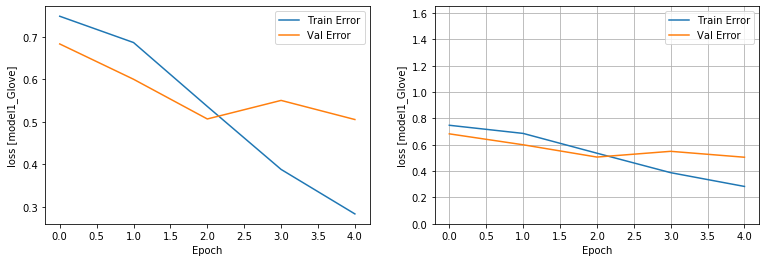

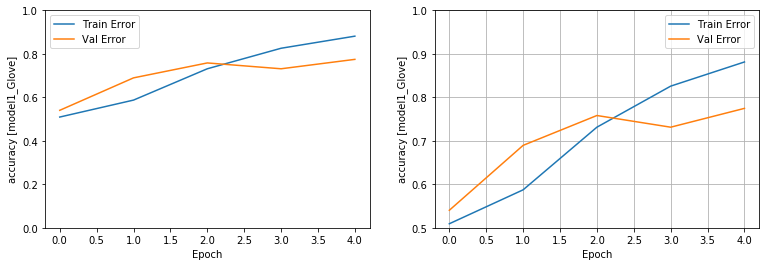

In [ ]:
plot_history(model1_history, "model1_Glove",metrics=["loss","accuracy"])

eval on test 

In [ ]:
print("train scores: ", end="")
train_stat = model.evaluate(X_train, y_train, verbose=2);
print("test scores: ", end="")
test_stat = model.evaluate(X_test, y_test, verbose=2);

train scores: 3350/3350 - 3s - loss: 0.2524 - accuracy: 0.9066
test scores: 1650/1650 - 2s - loss: 0.5263 - accuracy: 0.7636


# Model 2: domain spe. embed.
later try using **domain specific embeddings** which are **built by training models on millions of patent applications**

build your keras model to fine-tune the pretrained models on downstream classification task

## pretrained domain specific embeddings

we will use this w2vec specially made for patent datasets:
https://www.kaggle.com/darshmso/w2vec-patent-domain

In [ ]:
EMBEDDING_DIM = 100 # for glove we used 50, now we will work with 100 dim

In [ ]:
embeddings_index = load_embedding_index_from_file("W2Vec_Patent_Domain.txt")

Loading embedding_index from: W2Vec_Patent_Domain.txt ...

In [ ]:
embedding_matrix = get_embedding_matrix_from_embeddings_index(embeddings_index, nb_unique_words, EMBEDDING_DIM )

[+] Proceeding with Embedding Matrix...
[i] Completed!


## layers

to have comparable results, we keep the same model

In [ ]:
inp = Input(shape=(MAX_SEQUENCE_LENGTH,))
# Embedding recoi des int et output une seq de embedding
# https://hpi.de/fileadmin/user_upload/fachgebiete/naumann/publications/2019/risch2019domainspecific.pdf
x = Embedding(nb_unique_words, EMBEDDING_DIM, weights=[embedding_matrix])(inp)
x.trainable = False
x = Bidirectional(CuDNNGRU(16, return_sequences=True))(x)
x = MaxPooling1D()(x)
x = Flatten()(x)
x = Dense(16, activation="tanh")(x)
x = Dropout(rate=0.15)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 100)          1632600   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 32)           11328     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 100, 32)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                51216     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0   

In [ ]:
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=['accuracy'])

## train

In [ ]:
history = model.fit([X_train],[y_train],
                    verbose=2,
                    epochs=5,
                    validation_split = 0.2,
                    # callbacks=[early_stop, reduce_lr_onPlateau, tensorboard_callback, ManualEarlyStopping()])
                   )

Train on 2680 samples, validate on 670 samples
Epoch 1/5
2680/2680 - 7s - loss: 0.6443 - accuracy: 0.6392 - val_loss: 0.5301 - val_accuracy: 0.7194
Epoch 2/5
2680/2680 - 2s - loss: 0.3930 - accuracy: 0.8302 - val_loss: 0.4649 - val_accuracy: 0.7776
Epoch 3/5
2680/2680 - 2s - loss: 0.2534 - accuracy: 0.9026 - val_loss: 0.5530 - val_accuracy: 0.7537
Epoch 4/5
2680/2680 - 2s - loss: 0.1527 - accuracy: 0.9481 - val_loss: 0.5167 - val_accuracy: 0.7881
Epoch 5/5
2680/2680 - 2s - loss: 0.0824 - accuracy: 0.9806 - val_loss: 0.5616 - val_accuracy: 0.8015


## Results

history.tail:
       loss  accuracy  val_loss  val_accuracy  epoch
0  0.644345  0.639179  0.530108      0.719403      0
1  0.392973  0.830224  0.464851      0.777612      1
2  0.253393  0.902612  0.552973      0.753731      2
3  0.152707  0.948134  0.516716      0.788060      3
4  0.082408  0.980597  0.561575      0.801493      4


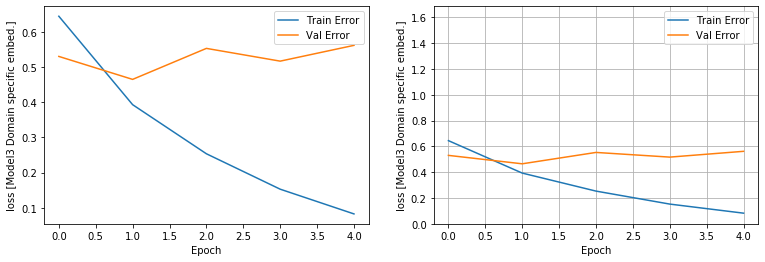

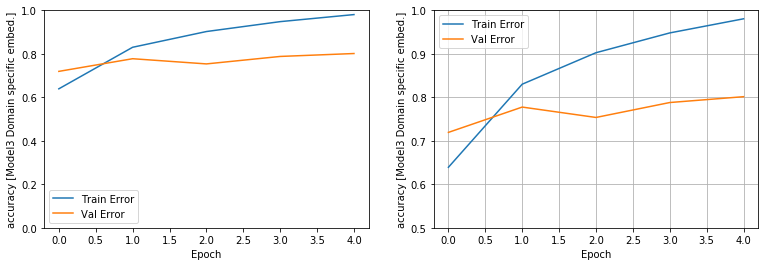

In [ ]:
plot_history(history, "Model3 Domain specific embed.",metrics=['loss', 'accuracy'])

eval on test 

In [ ]:
print("train scores: ", end="")
train_stat = model.evaluate(X_train, y_train, verbose=2);
print("test scores: ", end="")
test_stat = model.evaluate(X_test, y_test, verbose=2);

train scores: 3350/3350 - 2s - loss: 0.1378 - accuracy: 0.9582
test scores: 1650/1650 - 2s - loss: 0.5768 - accuracy: 0.7982


# Model 3: Pre-trained GPT-2

used this code to download gpt-2 124M:
https://github.com/openai/gpt-2/blob/master/download_model.py

download pre trained

In [ ]:
import os
import sys
import requests
from tqdm import tqdm

#if len(sys.argv) != 2:
#    print('You must enter the model name as a parameter, e.g.: download_model.py 124M')
#    sys.exit(1)

model = "124M"

subdir = os.path.join('models', model)
if not os.path.exists(subdir):
    os.makedirs(subdir)
subdir = subdir.replace('\\','/') # needed for Windows

for filename in ['checkpoint','encoder.json','hparams.json','model.ckpt.data-00000-of-00001', 'model.ckpt.index', 'model.ckpt.meta', 'vocab.bpe']:

    r = requests.get("https://storage.googleapis.com/gpt-2/" + subdir + "/" + filename, stream=True)

    with open(os.path.join(subdir, filename), 'wb') as f:
        file_size = int(r.headers["content-length"])
        chunk_size = 1000
        with tqdm(ncols=100, desc="Fetching " + filename, total=file_size, unit_scale=True) as pbar:
            # 1k for chunk_size, since Ethernet packet size is around 1500 bytes
            for chunk in r.iter_content(chunk_size=chunk_size):
                f.write(chunk)
                pbar.update(chunk_size)

load model and weights

In [ ]:
import os
import sys
from keras_gpt_2 import load_trained_model_from_checkpoint, get_bpe_from_files, generate


model_folder = r"C:\Users\Karim\Google Drive\AAA\Deep learning\4-projet\models\124M"
config_path = os.path.join(model_folder, 'hparams.json')
checkpoint_path = os.path.join(model_folder, 'model.ckpt')
encoder_path = os.path.join(model_folder, 'encoder.json')
vocab_path = os.path.join(model_folder, 'vocab.bpe')


print('Load model from checkpoint...')
model = load_trained_model_from_checkpoint(config_path, checkpoint_path)
print('Load BPE from files...')
bpe = get_bpe_from_files(encoder_path, vocab_path)
#print('Generate text...')
#output = generate(model, bpe, ['From the day forth, my arm'], length=20, top_k=40)
model.summary()

Load model from checkpoint...
Load BPE from files...
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              (None, None)         0                                            
__________________________________________________________________________________________________
Embed-Token (EmbeddingRet)      [(None, None, 768),  38597376    Input[0][0]                      
__________________________________________________________________________________________________
Embed-Token-Pos (PositionEmbedd (None, None, 768)    786432      Embed-Token[0][0]                
__________________________________________________________________________________________________
Encode-0-MultiHeadAtt-Norm (Lay (None, None, 768)    1536        Embed-Token-Pos[0][0]            
_______________________________________

## change model's head
delete last layer that output word embedding

In [ ]:
model.layers.pop() # delete last layer that output word embedding

# freeze all loaded layers
for layer in model.layers:
    layer.trainable=False
#compile to apply the .trainable change 
model.compile(input=model.input,output=model.layers[-1],loss="binary_crossentropy", optimizer="rmsprop", metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              (None, None)         0                                            
__________________________________________________________________________________________________
Embed-Token (EmbeddingRet)      [(None, None, 768),  38597376    Input[0][0]                      
__________________________________________________________________________________________________
Embed-Token-Pos (PositionEmbedd (None, None, 768)    786432      Embed-Token[0][0]                
__________________________________________________________________________________________________
Encode-0-MultiHeadAtt-Norm (Lay (None, None, 768)    1536        Embed-Token-Pos[0][0]            
____________________________________________________________________________________________

In [ ]:
# .GlobalMaxPool1D is a must here because we do not know the sentence's length
GlobalmaxPool = keras.layers.GlobalMaxPool1D(input_shape=(None,768))(model.layers[-1].output)
output_layer = keras.layers.Dense(1, activation="sigmoid")(GlobalmaxPool)

model = keras.Model(input=model.input,output=output_layer) # re-define input and output of the graph
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=['accuracy'])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              (None, None)         0                                            
__________________________________________________________________________________________________
Embed-Token (EmbeddingRet)      [(None, None, 768),  38597376    Input[0][0]                      
__________________________________________________________________________________________________
Embed-Token-Pos (PositionEmbedd (None, None, 768)    786432      Embed-Token[0][0]                
__________________________________________________________________________________________________
Encode-0-MultiHeadAtt-Norm (Lay (None, None, 768)    1536        Embed-Token-Pos[0][0]            
____________________________________________________________________________________________

C:\ProgramData\Anaconda3\envs\tensor-env\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("In..., outputs=Tensor("de...)`
  after removing the cwd from sys.path.


In [ ]:
import tensorflow as tf
# tf.config.gpu.set_per_process_memory_fraction(0.75)
# tf.config.gpu.set_per_process_memory_growth(True)

Solve the problem of the GPU memory limit

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print("error:", e)

error Physical devices cannot be modified after being initialized


In [ ]:
# test if the model works
prediction = model.predict([input_data[:10]], batch_size=12, verbose=1)
prediction[:5]

5000/5000 [==============================] - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 

array([[2.3222626e-06],
       [4.3641367e-06],
       [5.6475824e-07],
       [2.8034700e-07],
       [1.4636578e-07]], dtype=float32)

## train

In [ ]:
history = model.fit([X_train],[y_train],
                    verbose=2,
                    epochs=5,
                    batch_size=12, # must use a low batch size. batch_size=1024 will not work on a GTX 1060 
                    validation_split = 0.2,
                    # callbacks=[early_stop, reduce_lr_onPlateau, tensorboard_callback, ManualEarlyStopping()])
                   )

Train on 2680 samples, validate on 670 samples
Epoch 1/5
 - 78s - loss: 0.8879 - accuracy: 0.5269 - val_loss: 1.0887 - val_accuracy: 0.4910
Epoch 2/5
 - 77s - loss: 0.7603 - accuracy: 0.5396 - val_loss: 1.0138 - val_accuracy: 0.5060
Epoch 3/5
 - 77s - loss: 0.7399 - accuracy: 0.5578 - val_loss: 0.8373 - val_accuracy: 0.5090
Epoch 4/5
 - 77s - loss: 0.7188 - accuracy: 0.5728 - val_loss: 0.7788 - val_accuracy: 0.5164
Epoch 5/5
 - 77s - loss: 0.7010 - accuracy: 0.5690 - val_loss: 0.6697 - val_accuracy: 0.5940


## Results

history.tail:
   val_loss  val_accuracy      loss  accuracy  epoch
0  1.088707      0.491045  0.887915  0.526866      0
1  1.013805      0.505970  0.760267  0.539552      1
2  0.837253      0.508955  0.739947  0.557836      2
3  0.778797      0.516418  0.718759  0.572761      3
4  0.669657      0.594030  0.701006  0.569030      4


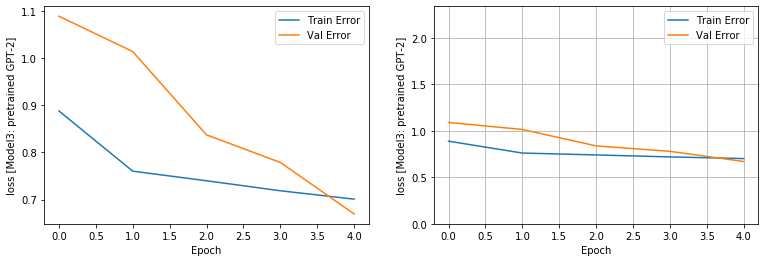

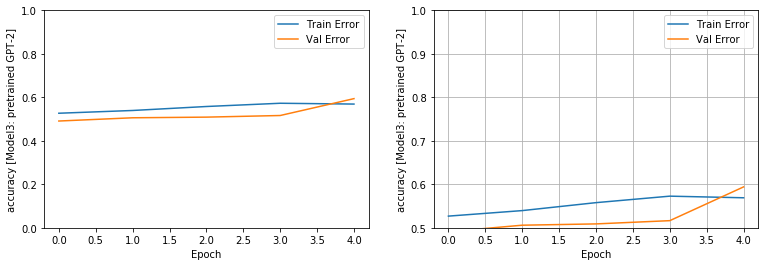

In [ ]:
plot_history(history, "Model3: pretrained GPT-2",metrics=["loss","accuracy"])

**Conclusion:**
For almost the same training time ( 5 min, 5 epoch) simple models have a higher accuracy.
Since the chosen problem is very simple, we do not need a pre-trained model.
Nevertheless, we expect that with a longer training period, the modified GPT-2 model will achieve higher accuracy